In [9]:
# Setting up API constants
api_url = "https://us-south.ml.cloud.ibm.com/ml/v1/time_series/forecast?version=2024-11-15"
api_key = "your_key"
project_id = "your_project"
    

# IAM endpoint and request data
iam_endpoint = "https://iam.cloud.ibm.com/identity/token"
headers = {
    "Content-Type": "application/x-www-form-urlencoded",
    "Accept": "application/json"
}
data = {
    "apikey": api_key,
    "grant_type": "urn:ibm:params:oauth:grant-type:apikey"
}
response = requests.post(iam_endpoint, headers=headers, data=data)

if response.status_code == 200:
    token_response = response.json()
    token = token_response['access_token']
else:
    raise Exception(f"Failed to fetch IBM token: {response.status_code} - {response.text}")


                  date ids  consumption-kwh
0  2024-08-01T00:00:00   A            1.398
1  2024-08-01T01:00:00   A            1.219
2  2024-08-01T02:00:00   A            0.969
3  2024-08-01T03:00:00   A            1.466
4  2024-08-01T04:00:00   A            1.260
Forecast successful!


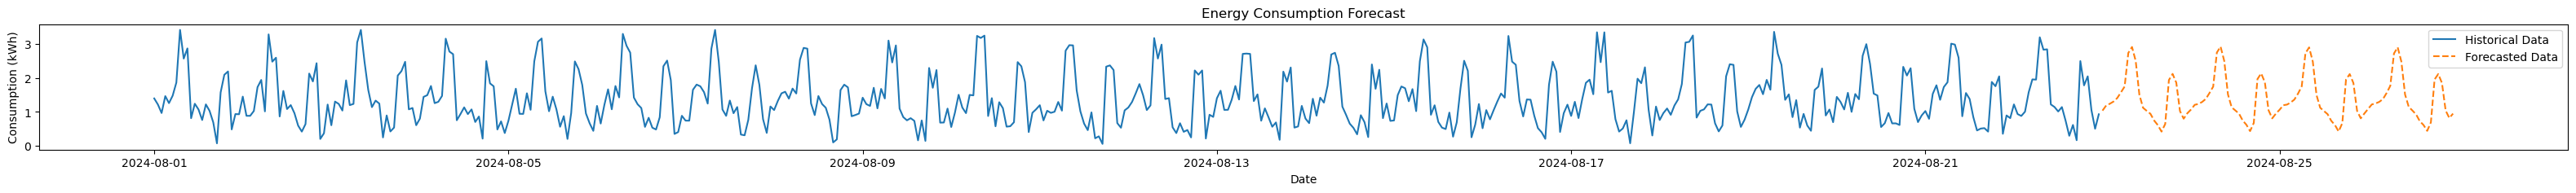

In [45]:
# Importing necessary libraries
import requests
import pandas as pd
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import math
import random

# generate synthetic sample data (to replace with your data points)
def generate_synthetic_data(start_date, num_hours):
    data = []
    date = datetime.fromisoformat(start_date)
    for i in range(num_hours):
        hour_of_day = (i % 24)  
        base_consumption = 1.0 + 0.5 * math.sin(2 * math.pi * hour_of_day / 24)
        
        if 7 <= hour_of_day <= 9 or 18 <= hour_of_day <= 20:
            peak_consumption = 1.5 
        else:
            peak_consumption = 0
        
        random_factor = random.uniform(-0.5, 0.5)
        consumption_value = round(base_consumption + peak_consumption + random_factor, 3)
        data.append({
            "date": (date + timedelta(hours=i)).isoformat(),
            "ids": "A",
            "consumption-kwh": max(consumption_value, 0) 
        })
    return pd.DataFrame(data)

# Generating example data
historical_data = generate_synthetic_data("2024-08-01T00:00:00", 528)
print(historical_data.head())

# Preparing the request body
request_payload = {
    "model_id": "ibm/granite-ttm-512-96-r2",
    "project_id": project_id,
    "schema": {
        "timestamp_column": "date",
        "id_columns": ["ids"],
        "freq": "1h",
        "target_columns": ["consumption-kwh"]
    },
    "data": {
        "date": historical_data["date"].tolist(),
        "ids": historical_data["ids"].tolist(),
        "consumption-kwh": historical_data["consumption-kwh"].tolist()
    }
}

# Making the API call
headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
    "Authorization": f"Bearer {token}"
}

response = requests.post(api_url, headers=headers, data=json.dumps(request_payload))

# Checking the response
if response.status_code == 200:
    forecast_result = response.json()
    print("Forecast successful!")
else:
    print(f"Error: {response.status_code}")
    print(response.text)

# Parsing and visualizing the forecast results
if response.status_code == 200:
    forecast_data = forecast_result["results"][0]
    forecast_df = pd.DataFrame({
        "date": forecast_data["date"],
        "forecasted_consumption": forecast_data["consumption-kwh"]
    })

    # Combine historical and forecast data for visualization
    forecast_df["date"] = pd.to_datetime(forecast_df["date"])
    historical_data["date"] = pd.to_datetime(historical_data["date"])
    

    plt.figure(figsize=(40, 2))
    plt.plot(historical_data["date"], historical_data["consumption-kwh"], label="Historical Data")
    plt.plot(forecast_df["date"], forecast_df["forecasted_consumption"], label="Forecasted Data", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("Consumption (kWh)")
    plt.title("Energy Consumption Forecast")
    plt.legend()
    plt.show()
